In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import datetime
import tensorflow as tf

# from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(14, 4), 
                     use_weekday_locator=False, use_year_locator=True, title=None, 
                     add_mark_at=None):
  fig, ax = plt.subplots(figsize=figsize)

  ax.plot(x, y)

  if use_weekday_locator:
    formatter = mdates.DateFormatter("%a")
    locator = mdates.DayLocator(interval=1)
  elif use_year_locator:
    formatter = mdates.DateFormatter("%d/%m/%Y")
    # locator = mdates.YearLocator(base=1)
    # formatter = mdates.DateFormatter("%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))

  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_year_locator or use_weekday_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_size(8)
      label.set_horizontalalignment('right')

  plt.show(fig)

In [4]:
def plot_time_series_data_window(
  x, y, xlabel="Time", ylabel="Value", figsize=(14, 4), 
  use_weekday_locator=False, use_year_locator=True, title=None, 
  add_mark_at=None, input_width=24, label_width=24):

  fig, ax = plt.subplots(figsize=figsize)

  num_of_rows = len(x)
  data_window_size = input_width + label_width
  num_of_data_window = num_of_rows // data_window_size
  input_color = "tab:blue" 
  label_color = "tab:orange" 
  
  for i in range(num_of_data_window):
    start_width_idx = i*data_window_size
    end_width_idx = i*data_window_size + input_width
    ax.plot(x.iloc[start_width_idx:end_width_idx], 
            y.iloc[start_width_idx:end_width_idx], color=input_color, 
            marker="s")
    
    start_label_idx = i*data_window_size + input_width
    end_label_idx = i*data_window_size + input_width + label_width
    ax.plot(x.iloc[start_label_idx:end_label_idx], 
            y.iloc[start_label_idx:end_label_idx], color=label_color, 
            marker="x")
        
  if use_weekday_locator:
    formatter = mdates.DateFormatter("%a")
    locator = mdates.DayLocator(interval=1)
  elif use_year_locator:
    formatter = mdates.DateFormatter("%d/%m/%Y")
    # locator = mdates.YearLocator(base=1)
    # formatter = mdates.DateFormatter("%Y")
    locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))

  ax.xaxis.set_major_formatter(formatter)
  ax.xaxis.set_major_locator(locator)
  
  if add_mark_at:
    x_loc, cycle_length = add_mark_at
    ax.plot(x[x_loc::cycle_length], y[x_loc::cycle_length], linestyle="None",
      marker='o', markerfacecolor='w', markeredgewidth=2, 
      markeredgecolor="tab:blue")

  ax.grid("on")
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if title is not None:
    ax.set_title(title)

  if use_year_locator or use_weekday_locator:
    for j, label in enumerate(ax.get_xticklabels()):
      label.set_rotation(40)
      label.set_size(8)
      label.set_horizontalalignment('right')

  plt.show(fig)

### Load

In [5]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [6]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [7]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,44


In [8]:
df_J = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "H"].copy()
df_J

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
12,2021-01-05,JULI HARJANTO,JL BLORA,KLANDASAN ILIR,BALIKPAPAN KOTA,LAKI-LAKI,1977-07-18,Pegawai Swasta-Jasa,"< Rp. 900.000,-",SLTA/SMU,HZ3,H,INDIVIDU,47
13,2021-01-06,"DHINA R. AGUSTIANA DA, SE",JL MASJID AR RAUDAH I,GUNUNG BAHAGIA,BALIKPAPAN SELATAN,PEREMPUAN,1974-08-13,IBU RUMAH TANGGA,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SARJANA,HWC,H,INDIVIDU,50
24,2021-01-07,AHMAD HABIBI HARAHAP,JL DAKSA TIMUR I,SEPINGGAN,BALIKPAPAN SELATAN,LAKI-LAKI,1995-04-30,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,HDN,H,INDIVIDU,29
31,2021-01-07,GALIH PUTRO WICAKSONO,JL JEND SUDIRMAN ASPOL STAL KUDA,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1993-05-26,TNI/POLRI,"< Rp. 900.000,-",AKADEMI/DIPLOMA,HZ3,H,INDIVIDU,31
37,2021-01-09,VELIANA FEBRIANTI,JL GUNUNG GEMBIRA,BARU ILIR,BALIKPAPAN BARAT,PEREMPUAN,1997-02-25,Pegawai Swasta-Perdagangan,"< Rp. 900.000,-",SLTA/SMU,HS2,H,INDIVIDU,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5956,2024-04-06,ERNIE DIANA NUR,JL. SIDOMULYO,MARGO MULYO,BALIKPAPAN BARAT,PEREMPUAN,1977-08-14,IBU RUMAH TANGGA,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,HDP,H,INDIVIDU,47
6330,2024-06-06,ERNI,JL. WOLTET MONGINSIDI GG. MACAN,BARU ULU,BALIKPAPAN BARAT,PEREMPUAN,1977-07-07,Wiraswasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,HD7,H,INDIVIDU,47
6351,2024-06-10,ZULFIKAR,JL TELINDUNG,BATU AMPAR,BALIKPAPAN UTARA,LAKI-LAKI,1988-02-07,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,HJ9,H,INDIVIDU,37
6501,2024-07-08,JOSUA,JL JENDRAL SUDIRMAN,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,2000-07-22,Pegawai Swasta-Jasa,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,HDN,H,INDIVIDU,24


In [9]:
df_J_count = df_J[["Tgl. Mohon"]].copy()
df_J_count["count"] = 1.
df_J_count = df_J_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_J_count["cumulative_sum"] = df_J_count["count"].cumsum()
df_J_count

,Tgl. Mohon,count,cumulative_sum
0,2021-01-05,1,1
1,2021-01-06,1,2
2,2021-01-07,2,4
3,2021-01-09,1,5
4,2021-01-11,1,6
...,...,...,...
295,2024-04-06,1,443
296,2024-06-06,1,444
297,2024-06-10,1,445
298,2024-07-08,1,446


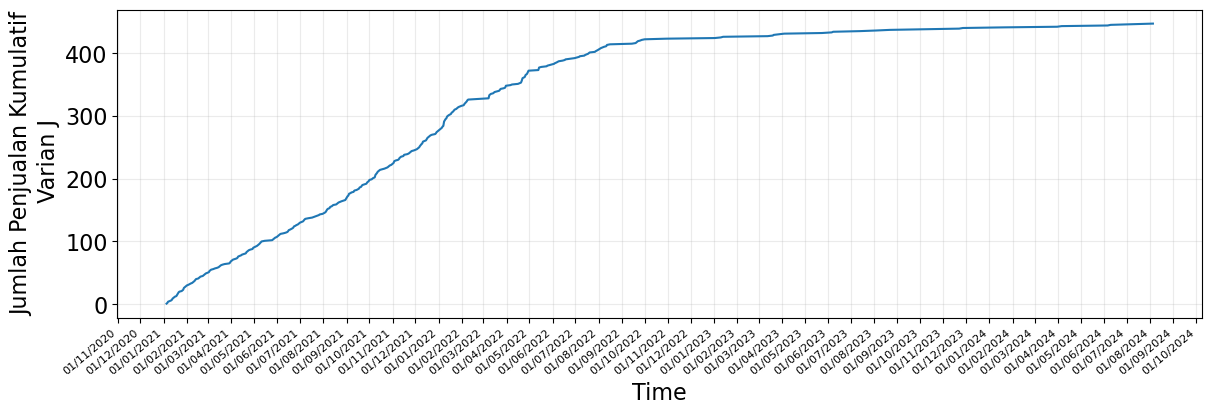

In [10]:
plot_time_series(df_J_count["Tgl. Mohon"], df_J_count["cumulative_sum"], use_year_locator=True, 
                  ylabel="Jumlah Penjualan Kumulatif\n Varian J")

## Feature engineering

In [11]:
df_J_count.describe()

,Tgl. Mohon,count,cumulative_sum
count,300,300.000000,300.000000
mean,2021-12-03 11:07:12,1.490000,225.103333
min,2021-01-05 00:00:00,1.000000,1.000000
25%,2021-06-02 06:00:00,1.000000,109.250000
50%,2021-10-25 12:00:00,1.000000,218.500000
75%,2022-04-10 00:00:00,2.000000,350.250000
max,2024-08-05 00:00:00,7.000000,447.000000
std,NaN,0.855769,136.600580


- Karena `count` mayoritas tanggal hanya memiliki 1 permohonan, dan hanya sebagian kecil yang mengalami lonjakan signifikan seperti 7.
- Kolom `cumulative_sum` tidak cocok untuk digunakan langsung dalam prediksi karena secara definisi selalu meningkat namun bisa digunakan untuk membuat fitur baru seperti jumlah permohonan dalam periode tertentu (sliding window) atau perubahan kumulatif
- Encoding waktu ke bentuk sin dan cos agar model dapat mengenali pola musiman

yang dilakukan
1. Mengurutkan data berdasarkan tanggal permohonan untuk rolling window
2. Menambah fitur baru:
    - `rolling_7days` untuk jumlah permohonan dalam 7 hari terakhir
    - `rolling_std_7d` untuk melihat fluktuasi (standar deviasi) permintaan dalam 7 hari terakhir
    - `delta_count` untuk melihat selisih jumlah permohonan di hari sebelumnya
    - `month` untuk melihat pola data lebih banyak di bulan apa
    - `weekday` untuk melihat pola data lebih banyak di awal atau alhir minggu

### Add Fitur

In [12]:
df_J_rolling = df_J_count.copy()
df_J_rolling = df_J_rolling.sort_values("Tgl. Mohon").reset_index(drop=True)

# Rolling jumlah permohonan 7 hari terakhir
df_J_rolling["rolling_7days"] = df_J_rolling["count"].rolling(window=7, min_periods=1).sum()

# Rolling jumlah data aktif 7 hari terakhir
df_J_rolling["rolling_count_7d"] = df_J_rolling["count"].rolling(window=7, min_periods=1).count()

# Perubahan permohonan/selisih dari hari sebelumnya
df_J_rolling['delta_count'] = df_J_rolling['count'].diff().fillna(0)

# Ekstraksi informasi waktu
df_J_rolling['month'] = df_J_rolling['Tgl. Mohon'].dt.month
df_J_rolling['weekday'] = df_J_rolling['Tgl. Mohon'].dt.weekday
df_J_rolling

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_count_7d,delta_count,month,weekday
0,2021-01-05,1,1,1.0,1.0,0.0,1,1
1,2021-01-06,1,2,2.0,2.0,0.0,1,2
2,2021-01-07,2,4,4.0,3.0,1.0,1,3
3,2021-01-09,1,5,5.0,4.0,-1.0,1,5
4,2021-01-11,1,6,6.0,5.0,0.0,1,0
...,...,...,...,...,...,...,...,...
295,2024-04-06,1,443,7.0,7.0,0.0,4,5
296,2024-06-06,1,444,7.0,7.0,0.0,6,3
297,2024-06-10,1,445,7.0,7.0,0.0,6,0
298,2024-07-08,1,446,7.0,7.0,0.0,7,0


### Encoding untuk waktu ke data kategori harian (sin cos)

3. Menambah fitur baru
    - `month_sin` dan `month_cos` untuk merepresentasikan nilai bulan Jan = 1 sampai Des = 12 secara periodik (siklikal), misalnya untuk menangani bulan Des (12) ke Jan (1) berdekatan dalam waktu, namun secara numerik 12 dan 1 terlihat jauh karena model tidak mengerti bahwa bulan itu berulang
    - `weekday_sin` dan `weekday_cos` untuk merepresentasikan hari dalam mingguan Senin = 0, Minggu = 6 secara siklikal
sehingga dengan sinus dan cosinus dapat membuat cyclical encoding (lingkaran) agar model bisa menangkap pola berulang karena berada pada sudut yang mirip di lingkaran. 

In [13]:
df_J_rolling['month_sin'] = np.sin(2 * np.pi * df_J_rolling['month'] / 12)
df_J_rolling['month_cos'] = np.cos(2 * np.pi * df_J_rolling['month'] / 12)

df_J_rolling['weekday_sin'] = np.sin(2 * np.pi * df_J_rolling['weekday'] / 7)
df_J_rolling['weekday_cos'] = np.cos(2 * np.pi * df_J_rolling['weekday'] / 7)
df_J_rolling

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-05,1,1,1.0,1.0,0.0,1,1,5.000000e-01,0.866025,0.781831,0.623490
1,2021-01-06,1,2,2.0,2.0,0.0,1,2,5.000000e-01,0.866025,0.974928,-0.222521
2,2021-01-07,2,4,4.0,3.0,1.0,1,3,5.000000e-01,0.866025,0.433884,-0.900969
3,2021-01-09,1,5,5.0,4.0,-1.0,1,5,5.000000e-01,0.866025,-0.974928,-0.222521
4,2021-01-11,1,6,6.0,5.0,0.0,1,0,5.000000e-01,0.866025,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
295,2024-04-06,1,443,7.0,7.0,0.0,4,5,8.660254e-01,-0.500000,-0.974928,-0.222521
296,2024-06-06,1,444,7.0,7.0,0.0,6,3,1.224647e-16,-1.000000,0.433884,-0.900969
297,2024-06-10,1,445,7.0,7.0,0.0,6,0,1.224647e-16,-1.000000,0.000000,1.000000
298,2024-07-08,1,446,7.0,7.0,0.0,7,0,-5.000000e-01,-0.866025,0.000000,1.000000


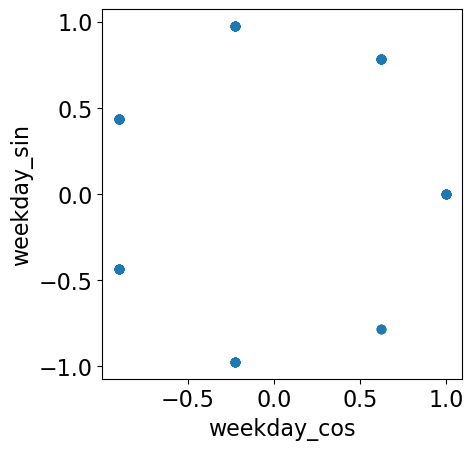

In [14]:
n_sample = 100   # randomly sample from the df_J_rolling

fig, ax = plt.subplots()

sampled_data = df_J_rolling.sample(n_sample)
ax.plot(sampled_data["weekday_cos"], sampled_data["weekday_sin"], linestyle="none",
        marker="o")

ax.set_aspect("equal")
ax.set_xlabel("weekday_cos")
ax.set_ylabel("weekday_sin")
plt.show(fig)

### Data Splitting

In [15]:
n_data = len(df_J_rolling)

# We drop "date_time" column because we never use it
# But for week-14, we need this column for plotting, so do not drop it
# df_traffic_selected_drop_date_time = df_J_rolling.drop(["date_time"], axis=1)

# Split 70:20:10 (train:validation:set)
idx_train = int(n_data * 0.7)
idx_test = int(n_data * 0.9)
# train_df = df_traffic_selected_drop_date_time[:idx_train].copy()
# val_df = df_traffic_selected_drop_date_time[idx_train:idx_test].copy()
# test_df = df_traffic_selected_drop_date_time[idx_test:].copy()

train_df = df_J_rolling[:idx_train].copy()
val_df = df_J_rolling[idx_train:idx_test].copy()
test_df = df_J_rolling[idx_test:].copy()


print(f"len(train, val, test): {len(train_df), len(val_df), len(test_df)}")

len(train, val, test): (210, 60, 30)


In [16]:
train_df

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-05,1,1,1.0,1.0,0.0,1,1,0.500000,0.866025,0.781831,0.623490
1,2021-01-06,1,2,2.0,2.0,0.0,1,2,0.500000,0.866025,0.974928,-0.222521
2,2021-01-07,2,4,4.0,3.0,1.0,1,3,0.500000,0.866025,0.433884,-0.900969
3,2021-01-09,1,5,5.0,4.0,-1.0,1,5,0.500000,0.866025,-0.974928,-0.222521
4,2021-01-11,1,6,6.0,5.0,0.0,1,0,0.500000,0.866025,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
205,2022-02-03,1,317,12.0,7.0,-1.0,2,3,0.866025,0.500000,0.433884,-0.900969
206,2022-02-04,2,319,12.0,7.0,1.0,2,4,0.866025,0.500000,-0.433884,-0.900969
207,2022-02-07,4,323,13.0,7.0,2.0,2,0,0.866025,0.500000,0.000000,1.000000
208,2022-02-08,2,325,14.0,7.0,-2.0,2,1,0.866025,0.500000,0.781831,0.623490


C:\Users\TEMP\AppData\Local\Temp\ipykernel_7124\2011438470.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


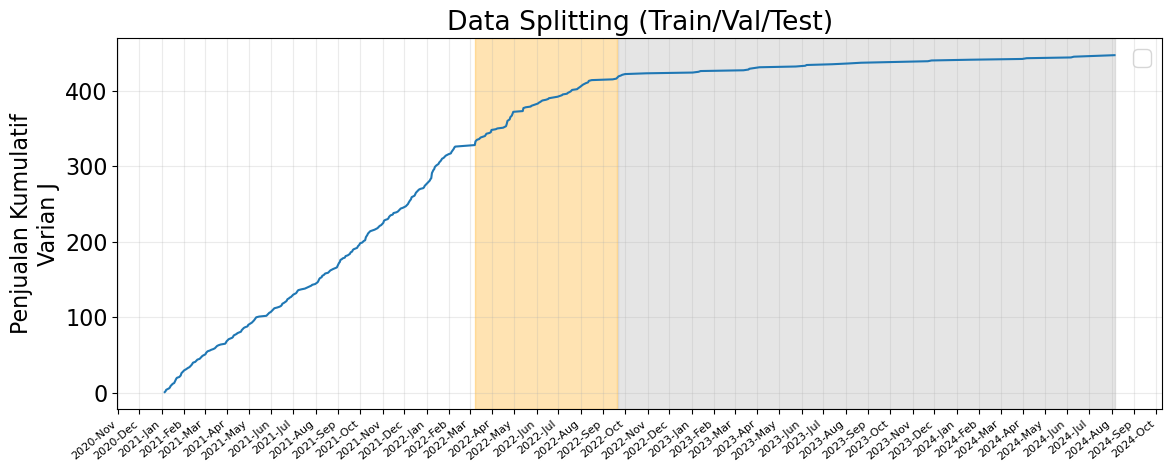

In [17]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(df_J_rolling['Tgl. Mohon'], df_J_rolling["cumulative_sum"])
ax.grid("on")
ax.set_ylabel("Penjualan Kumulatif\nVarian J")
ax.set_title("Data Splitting (Train/Val/Test)")
ax.legend()
# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# add forecast area
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], val_df['Tgl. Mohon'].iloc[-1], 
           color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df['Tgl. Mohon'].iloc[0], test_df['Tgl. Mohon'].iloc[-1], 
           color="#808080", alpha=0.2, label="Test")

for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_fontsize(8)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()


scaling data

In [18]:
column_for_scaling = ["count", "cumulative_sum", "rolling_7days", 
                    "rolling_count_7d", "delta_count", "month", "weekday",
                    "month_sin", "month_cos", "weekday_sin", "weekday_cos"]

# Define a scaler object
scaler_obj = MinMaxScaler()
scaler_obj.fit(train_df[column_for_scaling])

train_scale_df_j = train_df.copy()
val_scale_df_j = val_df.copy()
test_scale_df_j = test_df.copy()

train_scale_df_j[column_for_scaling] = scaler_obj.transform(train_scale_df_j[column_for_scaling])
val_scale_df_j[column_for_scaling] = scaler_obj.transform(val_scale_df_j[column_for_scaling])
test_scale_df_j[column_for_scaling] = scaler_obj.transform(test_scale_df_j[column_for_scaling])

display(train_scale_df_j.head())
display(val_scale_df_j.head())
display(test_scale_df_j.head())

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-05,0.000000,0.000000,0.00,0.000000,0.333333,0.0,0.166667,0.75,0.933013,0.900969,8.019377e-01
1,2021-01-06,0.000000,0.003077,0.05,0.166667,0.333333,0.0,0.333333,0.75,0.933013,1.000000,3.568959e-01
2,2021-01-07,0.166667,0.009231,0.15,0.333333,0.444444,0.0,0.500000,0.75,0.933013,0.722521,5.551115e-17
3,2021-01-09,0.000000,0.012308,0.20,0.500000,0.222222,0.0,0.833333,0.75,0.933013,0.000000,3.568959e-01
4,2021-01-11,0.000000,0.015385,0.25,0.666667,0.333333,0.0,0.000000,0.75,0.933013,0.500000,1.000000e+00


,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
210,2022-03-08,0.166667,1.006154,0.65,1.0,0.444444,0.181818,0.166667,1.0,0.5,0.900969,8.019377e-01
211,2022-03-09,0.666667,1.021538,0.80,1.0,0.666667,0.181818,0.333333,1.0,0.5,1.000000,3.568959e-01
212,2022-03-10,0.000000,1.024615,0.80,1.0,-0.111111,0.181818,0.500000,1.0,0.5,0.722521,5.551115e-17
213,2022-03-11,0.000000,1.027692,0.75,1.0,0.333333,0.181818,0.666667,1.0,0.5,0.277479,0.000000e+00
214,2022-03-14,0.000000,1.030769,0.60,1.0,0.333333,0.181818,0.000000,1.0,0.5,0.500000,1.000000e+00


,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
270,2022-09-21,0.0,1.283077,0.35,1.0,0.333333,0.727273,0.333333,0.000000,0.50,1.000000,3.568959e-01
271,2022-09-22,0.0,1.286154,0.35,1.0,0.333333,0.727273,0.500000,0.000000,0.50,0.722521,5.551115e-17
272,2022-09-25,0.0,1.289231,0.30,1.0,0.333333,0.727273,1.000000,0.000000,0.50,0.099031,8.019377e-01
273,2022-09-27,0.0,1.292308,0.30,1.0,0.333333,0.727273,0.166667,0.000000,0.50,0.900969,8.019377e-01
274,2022-10-01,0.0,1.295385,0.30,1.0,0.333333,0.818182,0.833333,0.066987,0.75,0.000000,3.568959e-01


In [19]:
train_scale_df_j.to_csv("./data/train_scale_j.csv", index=False)
val_scale_df_j.to_csv("./data/val_scale_j.csv", index=False)
test_scale_df_j.to_csv("./data/test_scale_j.csv", index=False)

In [20]:
dataset_section = ['train', 'val', 'test']
dataset = {}
for section in dataset_section:
  dataset[f"{section}_scale_df_j"] = pd.read_csv(f"./data/{section}_scale_j.csv",
                                                parse_dates=["Tgl. Mohon"])
dataset["train_scale_df_j"]

,Tgl. Mohon,count,cumulative_sum,rolling_7days,rolling_count_7d,delta_count,month,weekday,month_sin,month_cos,weekday_sin,weekday_cos
0,2021-01-05,0.000000,0.000000,0.00,0.000000,0.333333,0.000000,0.166667,0.750000,0.933013,0.900969,8.019377e-01
1,2021-01-06,0.000000,0.003077,0.05,0.166667,0.333333,0.000000,0.333333,0.750000,0.933013,1.000000,3.568959e-01
2,2021-01-07,0.166667,0.009231,0.15,0.333333,0.444444,0.000000,0.500000,0.750000,0.933013,0.722521,5.551115e-17
3,2021-01-09,0.000000,0.012308,0.20,0.500000,0.222222,0.000000,0.833333,0.750000,0.933013,0.000000,3.568959e-01
4,2021-01-11,0.000000,0.015385,0.25,0.666667,0.333333,0.000000,0.000000,0.750000,0.933013,0.500000,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
205,2022-02-03,0.000000,0.972308,0.55,1.000000,0.222222,0.090909,0.500000,0.933013,0.750000,0.722521,5.551115e-17
206,2022-02-04,0.166667,0.978462,0.55,1.000000,0.444444,0.090909,0.666667,0.933013,0.750000,0.277479,0.000000e+00
207,2022-02-07,0.500000,0.990769,0.60,1.000000,0.555556,0.090909,0.000000,0.933013,0.750000,0.500000,1.000000e+00
208,2022-02-08,0.166667,0.996923,0.65,1.000000,0.111111,0.090909,0.166667,0.933013,0.750000,0.900969,8.019377e-01


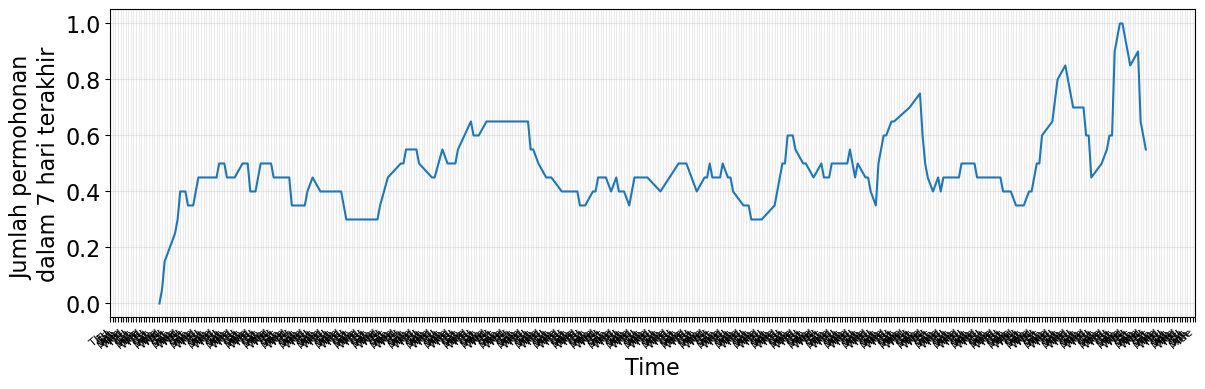

In [21]:
num_of_rows = 200
train_scale_df_j_selected = dataset["train_scale_df_j"]
plot_time_series(train_scale_df_j_selected.iloc[:num_of_rows]["Tgl. Mohon"], 
                  train_scale_df_j_selected.iloc[:num_of_rows]["rolling_7days"],
                  ylabel="Jumlah permohonan \ndalam 7 hari terakhir",
                  use_weekday_locator=True, use_year_locator=False)

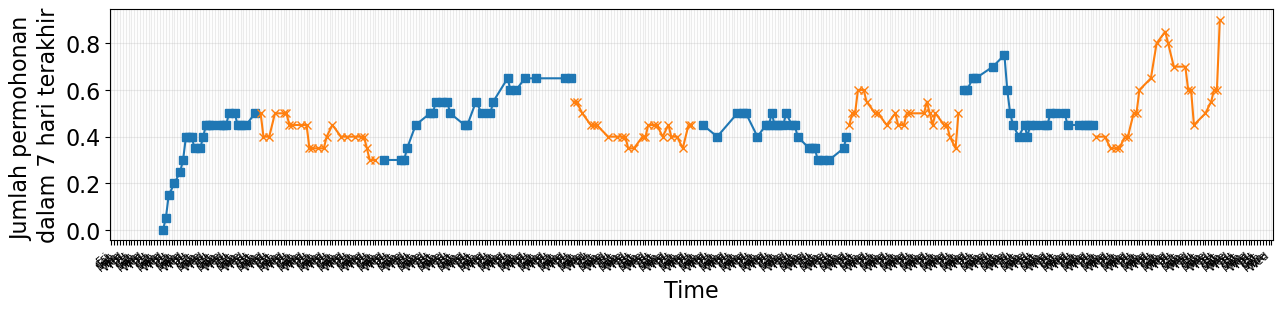

In [22]:
num_of_rows = 200
train_scale_df_j_selected = dataset["train_scale_df_j"]
plot_time_series_data_window(train_scale_df_j_selected.iloc[:num_of_rows]["Tgl. Mohon"], 
                  train_scale_df_j_selected.iloc[:num_of_rows]["rolling_7days"],
                  ylabel="Jumlah permohonan \ndalam 7 hari terakhir", figsize=(15, 3),
                  use_weekday_locator=True, use_year_locator=False)

## Model Development

In [23]:
feature_col = "rolling_7days"

# Fungsi untuk membuat sequence LSTM
def create_sequences(data_series, sequence_length):
    X, y = [], []
    for i in range(len(data_series) - sequence_length):
        seq = data_series[i:i + sequence_length]
        label = data_series[i + sequence_length]
        X.append(seq)
        y.append(label)
    return np.array(X), np.array(y)

In [24]:
# Set panjang sequence
sequence_length = 10  # Bisa di-tuning

train_series = dataset["train_scale_df_j"][feature_col].values
val_series = dataset["val_scale_df_j"][feature_col].values
test_series = dataset["test_scale_df_j"][feature_col].values

# Buat sequence
X_train, y_train = create_sequences(train_series, sequence_length)
X_val, y_val = create_sequences(val_series, sequence_length)
X_test, y_test = create_sequences(test_series, sequence_length)

# Reshape ke bentuk [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [25]:
# Bangun model LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

c:\ProgramData\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

### Data Training

epoch = 50

In [26]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                    epochs=50, batch_size=32, verbose=1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - loss: 0.2188 - val_loss: 0.0327
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0217 - val_loss: 0.0509
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0282 - val_loss: 0.0196
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0154 - val_loss: 0.0202
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0147 - val_loss: 0.0195
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0129 - val_loss: 0.0210
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0131 - val_loss: 0.0188
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0123 - val_loss: 0.0184
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0111 - val_loss: 0.0190
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0099 - val_loss: 0.0192
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0129 - val_loss: 0.0188
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0105 - val_loss: 0.0179


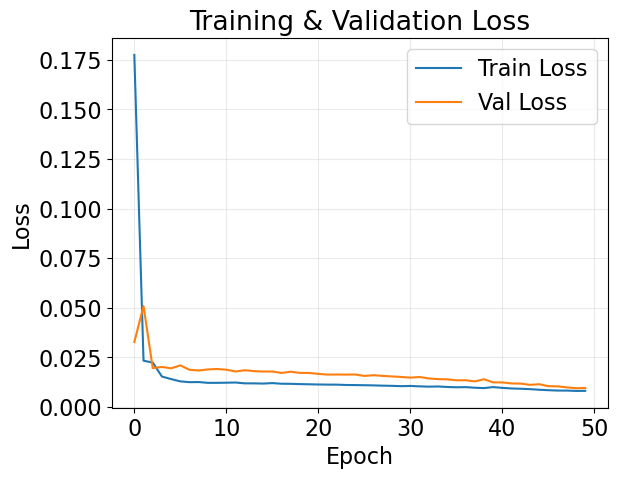

In [27]:
# Visualisasi loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid("on")
plt.show()

In [28]:
predictions = model.predict(X_test)

dummy_input = np.zeros((predictions.shape[0], len(column_for_scaling)))
rolling_index = column_for_scaling.index("rolling_7days")
dummy_input[:, rolling_index] = predictions[:, 0]

predictions_inverse = scaler_obj.inverse_transform(dummy_input)[:, rolling_index]


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [29]:
y_test_dummy = np.zeros((len(y_test), len(column_for_scaling)))
y_test_dummy[:, rolling_index] = y_test

y_test_inverse = scaler_obj.inverse_transform(y_test_dummy)[:, rolling_index]


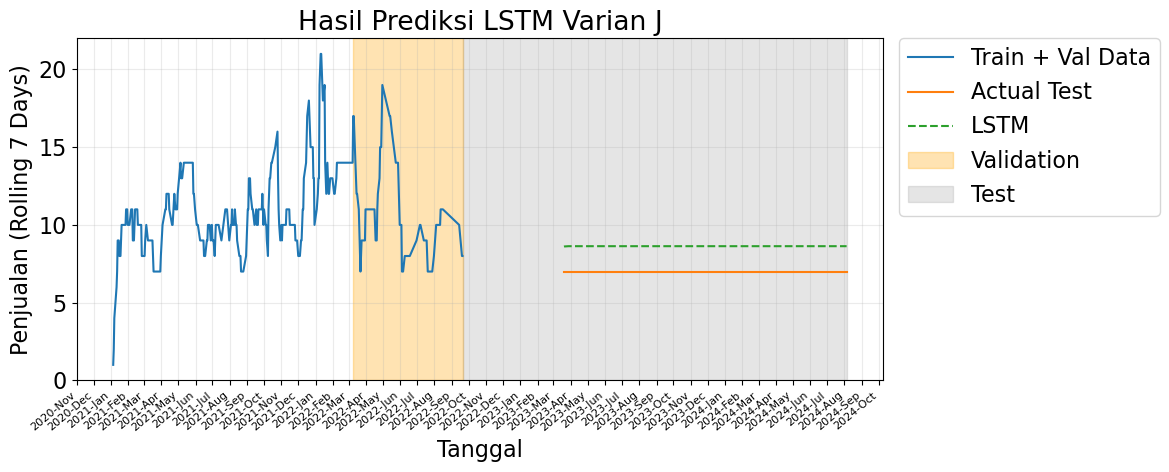

In [30]:
fig, ax = plt.subplots(figsize=(12, 5))

train_val_df = pd.concat([train_df, val_df], ignore_index=True)
ax.plot(train_val_df["Tgl. Mohon"], train_val_df["rolling_7days"], label="Train + Val Data")
ax.plot(test_df["Tgl. Mohon"][sequence_length:], y_test_inverse, label="Actual Test")
ax.plot(test_df["Tgl. Mohon"][sequence_length:], predictions_inverse, linestyle="--", label="LSTM")


# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

ax.set_xlabel("Tanggal")
ax.set_ylabel("Penjualan (Rolling 7 Days)")
ax.set_title("Hasil Prediksi LSTM Varian J")
ax.grid("on")

# add forecast area
ax.axvspan(val_df['Tgl. Mohon'].iloc[0], val_df['Tgl. Mohon'].iloc[-1], 
           color="orange", alpha=0.3, label="Validation")
ax.axvspan(test_df["Tgl. Mohon"].iloc[0], test_df["Tgl. Mohon"].iloc[-1], 
                    color="#808080", alpha=0.2, label="Test")

for label in ax.get_xticklabels():
    label.set_rotation(40)
    label.set_fontsize(8)
    label.set_horizontalalignment('right')

ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1), borderaxespad=0.)

plt.tight_layout()
plt.show()


In [31]:
# MAE
mae = mean_absolute_error(y_test_inverse, predictions_inverse)
# MAPE
mape = np.mean(np.abs((y_test_inverse - predictions_inverse) / np.where(y_test_inverse == 0, 1, y_test_inverse))) * 100
# MSE
mse = mean_squared_error(y_test_inverse, predictions_inverse)
# RMSE
rmse = np.sqrt(mse)
# MASE
# prediksi naive (nilai sebelumnya)
naive_forecast = y_test_inverse[:-1]
true_values = y_test_inverse[1:]
mae_naive = mean_absolute_error(true_values, naive_forecast)
if mae_naive == 0:
    mase = np.nan  # atau kamu bisa pakai mase = float('inf')
else:
    mase = mae / mae_naive

print(f"MAE  : {mae:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"MSE  : {mse:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MASE : {mase:.2f}")


MAE  : 1.63
MAPE : 23.27%
MSE  : 2.65
RMSE : 1.63
MASE : nan
